# Yoga Pose Classification using ViT Transfer Learning in PyTorch | A setp by step guide.

<!-- !ipython nbconvert --to markdown notebook.ipynb -->

In [ ]:
# importing Libraries
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# downloading datasets
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# !unzip hymenoptera_data.zip
# rm -rf hymenoptera_data.zip

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(400),
        transforms.CenterCrop(384),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomGrayscale(),
        transforms.RandomAdjustSharpness(sharpness_factor=1,p=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(400),
        transforms.CenterCrop(384),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'yoga'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 1000
     Root location: yoga/train
     StandardTransform
 Transform: Compose(
                Resize(size=400, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(384, 384))
                RandomHorizontalFlip(p=0.5)
                ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
                RandomGrayscale(p=0.1)
                RandomAdjustSharpness(sharpness_factor=1,p=0.1)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 495
     Root location: yoga/val
     StandardTransform
 Transform: Compose(
                Resize(size=400, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(384, 384))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
   

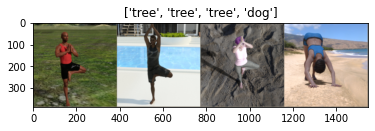

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# !pip install timm
import timm

class ViT(nn.Module):
    """ViT pretrained model definition."""
    def __init__(self, out_size: int):
        super(ViT, self).__init__()
        self.model = timm.create_model("vit_base_patch16_384", pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        in_features = 768
        self.model.head = nn.Sequential(
            nn.Linear(in_features, in_features*2),
            nn.Dropout(0.5),
            nn.Linear(in_features*2, in_features),
            nn.Dropout(0.30),
            nn.Linear(in_features, in_features//out_size),
            nn.Dropout(0.25),
            nn.Linear(in_features//out_size, out_size),
            nn.Softmax()
        ) 

    def forward(self, x):
        return self.model(x)

out_len = len(class_names)
vit = ViT(out_size = out_len)

In [ ]:
from tqdm import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = vit.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_final = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

# Save custom model
torch.save(model_final, "yoga_model.pth")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


train Loss: 1.5721 Acc: 0.3020


  5%|▌         | 1/20 [01:10<22:16, 70.32s/it]

val Loss: 1.5710 Acc: 0.2869

Epoch 1/19
----------
train Loss: 1.4692 Acc: 0.4990


 10%|█         | 2/20 [02:19<20:56, 69.81s/it]

val Loss: 1.5107 Acc: 0.4586

Epoch 2/19
----------
train Loss: 1.3550 Acc: 0.6630


 15%|█▌        | 3/20 [03:28<19:42, 69.54s/it]

val Loss: 1.4484 Acc: 0.6626

Epoch 3/19
----------
train Loss: 1.2532 Acc: 0.8030


 20%|██        | 4/20 [04:38<18:30, 69.39s/it]

val Loss: 1.4054 Acc: 0.6182

Epoch 4/19
----------
train Loss: 1.1693 Acc: 0.8660


 25%|██▌       | 5/20 [05:47<17:20, 69.36s/it]

val Loss: 1.3476 Acc: 0.7030

Epoch 5/19
----------
train Loss: 1.1064 Acc: 0.9140


 30%|███       | 6/20 [06:56<16:10, 69.34s/it]

val Loss: 1.3304 Acc: 0.6828

Epoch 6/19
----------
train Loss: 1.0646 Acc: 0.9300


 35%|███▌      | 7/20 [08:06<15:01, 69.31s/it]

val Loss: 1.2852 Acc: 0.7152

Epoch 7/19
----------
train Loss: 1.0456 Acc: 0.9420


 40%|████      | 8/20 [09:15<13:51, 69.32s/it]

val Loss: 1.2805 Acc: 0.7172

Epoch 8/19
----------
train Loss: 1.0360 Acc: 0.9460


 45%|████▌     | 9/20 [10:24<12:42, 69.30s/it]

val Loss: 1.2769 Acc: 0.7273

Epoch 9/19
----------
train Loss: 1.0368 Acc: 0.9560


 50%|█████     | 10/20 [11:33<11:32, 69.28s/it]

val Loss: 1.2764 Acc: 0.7192

Epoch 10/19
----------
train Loss: 1.0296 Acc: 0.9580


 55%|█████▌    | 11/20 [12:43<10:23, 69.32s/it]

val Loss: 1.2727 Acc: 0.7253

Epoch 11/19
----------
train Loss: 1.0251 Acc: 0.9490


 60%|██████    | 12/20 [13:52<09:15, 69.44s/it]

val Loss: 1.2700 Acc: 0.7253

Epoch 12/19
----------
train Loss: 1.0257 Acc: 0.9500


 65%|██████▌   | 13/20 [15:02<08:06, 69.53s/it]

val Loss: 1.2669 Acc: 0.7313

Epoch 13/19
----------
train Loss: 1.0229 Acc: 0.9490


 70%|███████   | 14/20 [16:12<06:57, 69.51s/it]

val Loss: 1.2632 Acc: 0.7333

Epoch 14/19
----------
train Loss: 1.0268 Acc: 0.9530


 75%|███████▌  | 15/20 [17:21<05:47, 69.44s/it]

val Loss: 1.2631 Acc: 0.7333

Epoch 15/19
----------
train Loss: 1.0191 Acc: 0.9580


 80%|████████  | 16/20 [18:30<04:37, 69.33s/it]

val Loss: 1.2631 Acc: 0.7354

Epoch 16/19
----------
train Loss: 1.0175 Acc: 0.9600


 85%|████████▌ | 17/20 [19:39<03:27, 69.31s/it]

val Loss: 1.2632 Acc: 0.7354

Epoch 17/19
----------
train Loss: 1.0206 Acc: 0.9570


 90%|█████████ | 18/20 [20:49<02:18, 69.28s/it]

val Loss: 1.2634 Acc: 0.7374

Epoch 18/19
----------
train Loss: 1.0290 Acc: 0.9490


 95%|█████████▌| 19/20 [21:58<01:09, 69.26s/it]

val Loss: 1.2631 Acc: 0.7354

Epoch 19/19
----------
train Loss: 1.0201 Acc: 0.9520


100%|██████████| 20/20 [23:07<00:00, 69.37s/it]

val Loss: 1.2630 Acc: 0.7354

Training complete in 23m 7s
Best val Acc: 0.737374


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


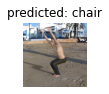

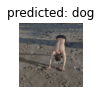

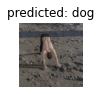

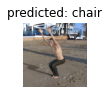

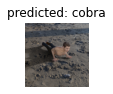

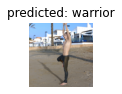

In [ ]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [ ]:
!wget http://download.tensorflow.org/data/pose_classification/yoga_poses.zip

--2022-10-04 15:04:23--  http://download.tensorflow.org/data/pose_classification/yoga_poses.zip
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.127.128, 2a00:1450:4013:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.127.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102517581 (98M) [application/zip]
Saving to: ‘yoga_poses.zip’

yoga_poses.zip      100%[===================>]  97.77M  32.0MB/s    in 3.1s    

2022-10-04 15:04:27 (32.0 MB/s) - ‘yoga_poses.zip’ saved [102517581/102517581]



In [ ]:
y_pred_list = []
y_true_list = []
test_loader = dataloaders["val"]
# load yoga model
model = torch.load("yoga_model.pth")
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        y_pred_tag = torch.argmax(y_test_pred, dim = 1)
        y_pred_list.extend(y_pred_tag.cpu().numpy().tolist())
        y_true_list.extend(y_batch.cpu().numpy().tolist())

  0%|          | 0/124 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 124/124 [00:23<00:00,  5.19it/s]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85        84
           1       1.00      0.76      0.86       116
           2       1.00      0.98      0.99        90
           3       0.46      0.56      0.51        96
           4       0.58      0.47      0.52       109

    accuracy                           0.74       495
   macro avg       0.76      0.75      0.74       495
weighted avg       0.76      0.74      0.74       495

[[84  0  0  0  0]
 [ 5 88  0 16  7]
 [ 1  0 88  0  1]
 [13  0  0 54 29]
 [11  0  0 47 51]]
